In [42]:
import pandas as pd
import numpy as np 
import seaborn as sns
from matplotlib import pyplot as plt
pd.options.mode.chained_assignment = None
from scipy.stats import mannwhitneyu
from statannotations.Annotator import Annotator
import random

In [43]:
def unique_patients(samples):
    df_samples = pd.DataFrame({ "samples" : samples, 
                            "patient" :["-".join(i.split("-")[:3]) for i in samples] })
    df_samples["plate"] = [i.split("-")[5] for i in df_samples["samples"]]
    df_samples = df_samples.sort_values(by = "plate", ascending= False) \
                .drop_duplicates(subset = "patient", keep = "first")
    return df_samples

def pair_sample(type):
    meta_data = pd.read_csv("../processed_data/meta/" + type + 
                            "_meta_filtered.csv")
    if type == "CRC":
        df_bn = pd.concat([pd.read_csv("../COAD/filtered_STR/COAD_bn.csv"),
                                pd.read_csv("../READ/filtered_STR/READ_bn.csv")]).reset_index()
        df_stn = pd.concat([pd.read_csv("../COAD/filtered_STR/COAD_stn.csv"),
                                pd.read_csv("../READ/filtered_STR/READ_stn.csv")]).reset_index()
        df_pt = pd.concat([pd.read_csv("../COAD/filtered_STR/COAD_pt.csv"),
                                pd.read_csv("../READ/filtered_STR/READ_pt.csv")]).reset_index()
    else: 
        df_bn = pd.read_csv("../" + type + "/filtered_STR/" + type + "_bn.csv")
        df_stn = pd.read_csv("../" + type + "/filtered_STR/" + type + "_stn.csv")
        df_pt = pd.read_csv("../" + type + "/filtered_STR/" + type + "_pt.csv")

    df_bn = pd.concat([df_bn, df_stn]).reset_index()
    df_bn = df_bn.loc[df_bn["sample"].isin(meta_data["name"]),]
    df_pt = df_pt.loc[df_pt["sample"].isin(meta_data["name"]),]

    # select unique samples 
    unique_bn = unique_patients(df_bn["sample"].unique())
    unique_pt = unique_patients(df_pt["sample"].unique())
    merge_sample = pd.merge(unique_bn, unique_pt, on = "patient")
    df_bn = df_bn.loc[df_bn["sample"].isin(merge_sample["samples_x"])]
    df_pt = df_pt.loc[df_pt["sample"].isin(merge_sample["samples_y"])]

    df_bn["patient"] = ["-".join(i.split("-")[:3]) for i in df_bn["sample"]]
    df_pt["patient"] = ["-".join(i.split("-")[:3]) for i in df_pt["sample"]]
    pt_ns = pd.merge(df_pt, df_bn, on = ["patient", "tmp_id"], suffixes=('_t', '_n'))

    # keep autosomal STRs only 
    pt_ns["chr"] = [i.split("_")[0] for i in pt_ns["tmp_id"]]
    pt_ns = pt_ns.loc[~pt_ns.chr.isin(["chrM", "chrX", "chrY"]),:]
    
    return pt_ns

In [44]:
cancer_type = "CRC"
df_str = pair_sample(cancer_type)

In [45]:
mask = ~((df_str.allele_a_t == df_str.allele_b_t) &   # homozygous in tumor
        (df_str.allele_a_t != df_str.allele_a_n) &  # not equal healthy allele a
        (df_str.allele_a_t != df_str.allele_b_n))   # ...or healthy allele b
df_str = df_str[mask]

In [46]:
df_str.shape

(11060423, 18)

In [47]:
def calc_len_differences(a: np.array, b: np.array, aprime: np.array, bprime: np.array):
    """
    Given four arrays of STR allele lengths (two from healthy samples, two from patient-matched tumor samples),
    calculate the smallest unit number difference that would transform  'a' and 'b' into 'a_prime' and 'b_prime'.
    To do this, calculate the difference for two scenarios:
        a -> a_prime & b -> b_prime 
        OR 
        a -> b_prime & b -> a_prime
    The scenario yielding the smallest unit difference between the alleles of the healthy sample and the tumor
    sample is assumed to be the most likely.
    """
    # make matrix to store results
    # res_m[0]: alle_a_differences, res_m[1]: allele_b_differences, res_m[2]: sum of absolute differences
    res_m = np.array(
        [
            np.zeros(len(a)),
            np.zeros(len(a)),
            np.zeros(len(a)),
        ]    
    )
    # Case where allele a healthy -> allele a tumor
    a_to_a = np.array([aprime-a, bprime-b])
    a_to_a_diff = np.abs(a_to_a).sum(axis=0)
    # Case where allele a healthy -> allele b tumor
    a_to_b = np.array([bprime-a, aprime-b])
    a_to_b_diff = np.abs(a_to_b).sum(axis=0)
    
    # Make boolian array for indexing, smallest difference between healthy and 
    # tumor is assumed most likely scenario
    comp = (a_to_a_diff >= a_to_b_diff)
    
    res_m[0:2, ~comp] = a_to_a[:, ~comp]
    res_m[0:2, comp] = a_to_b[:, comp]
    
    res_m[2, ~comp] = a_to_a_diff[~comp]
    res_m[2, comp] = a_to_b_diff[comp]
    
    return res_m.T

In [48]:
res = calc_len_differences(
    df_str.allele_a_n.to_numpy(),
    df_str.allele_b_n.to_numpy(),
    df_str.allele_a_t.to_numpy(),
    df_str.allele_b_t.to_numpy(),   
)
df_str[['allele_a_diff', 'allele_b_diff', 'patient_len_diff']] = pd.DataFrame(res, 
    index = df_str.index).astype(np.int32)

## eSTR mutatability

In [49]:
column_names = ["patient", "tmp_id", "period", "ref", "allele_a_healthy", "allele_a_tumor",
                "allele_b_healthy", "allele_b_tumor",  "allele_a_diff", "allele_b_diff", "patient_len_diff"]

df_out = df_str[["patient", "tmp_id", "period_t", "ref_t", "allele_a_n", "allele_a_t",
                "allele_b_n", "allele_b_t", "allele_a_diff", "allele_b_diff", "patient_len_diff"]]

df_out.columns = column_names

In [50]:
crc_p = pd.read_csv("./output/crc_gene_qtl.csv")
crc_f = crc_p.query("adj_p < 0.05")

In [51]:
df_estr = df_out.loc[df_out["tmp_id"].isin(crc_f["str_id"]),]
df_nestr = df_out.loc[df_out["tmp_id"].isin(crc_p.query(" adj_p > 0.05")["str_id"]),]
df_estr["patient"].nunique(), df_nestr["patient"].nunique()

(433, 433)

In [52]:
msi_info = pd.read_csv("../clinical/" + cancer_type + "_msi.csv")
msi_info.loc[msi_info["msi_status"] == "msi-l", "msi_status"] = "mss"
msi_info.loc[msi_info["msi_status"] == "indeterminate", "msi_status"] = "mss"

In [18]:
#df_estr = df_estr.groupby(["period", "ref"])["tmp_id"].count().reset_index().query(" tmp_id > 50 ")

In [68]:
df_estr_msi = df_estr.loc[df_estr["patient"].isin(msi_info.loc[msi_info["msi_status"] == "mss", "patient"])]
df_nestr_msi = df_nestr.loc[df_nestr["patient"].isin(msi_info.loc[msi_info["msi_status"] == "mss", "patient"])]

In [69]:
estr_msi_all = df_estr_msi.groupby(["period", "ref"])["tmp_id"].count().reset_index().query(" tmp_id > 100 ")
estr_msi_mu = df_estr_msi.query(" patient_len_diff != 0 ").groupby(["period", "ref"])["tmp_id"].count().reset_index()
type_es_msi = pd.merge(estr_msi_mu, estr_msi_all, on = ["period", "ref"])
type_es_msi["es_mu"] = type_es_msi["tmp_id_x"]/type_es_msi["tmp_id_y"]

nestr_msi_all = df_nestr_msi.groupby(["period", "ref"])["tmp_id"].count().reset_index().query(" tmp_id > 100 ")
nestr_msi_mu = df_nestr_msi.query(" patient_len_diff != 0 ").groupby(["period", "ref"])["tmp_id"].count().reset_index()
type_ne_msi = pd.merge(nestr_msi_mu, nestr_msi_all, on = ["period", "ref"])
type_ne_msi["ne_mu"] = type_ne_msi["tmp_id_x"]/type_ne_msi["tmp_id_y"]

com_msi = type_es_msi.merge(type_ne_msi, on = ["period", "ref"])

In [554]:
# estr_msi_all = df_estr_msi.groupby(["period"])["tmp_id"].count().reset_index() #.query(" tmp_id > 50 ")
# estr_msi_mu = df_estr_msi.query(" patient_len_diff != 0 ").groupby(["period"])["tmp_id"].count().reset_index()
# type_es_msi = pd.merge(estr_msi_mu, estr_msi_all, on = "period")
# type_es_msi["es_mu"] = type_es_msi["tmp_id_x"]/type_es_msi["tmp_id_y"]

# nestr_msi_all = df_nestr_msi.groupby(["period"])["tmp_id"].count().reset_index() #.query(" tmp_id > 50 ")
# nestr_msi_mu = df_nestr_msi.query(" patient_len_diff != 0 ").groupby(["period"])["tmp_id"].count().reset_index()
# type_ne_msi = pd.merge(nestr_msi_mu, nestr_msi_all, on = "period")
# type_ne_msi["ne_mu"] = type_ne_msi["tmp_id_x"]/type_ne_msi["tmp_id_y"]

# com_msi = type_es_msi.merge(type_ne_msi, on = "period")

In [64]:
com_msi = com_mss

In [70]:
com_mss.shape#, com_msi.shape

(48, 8)

In [65]:
mss_mu = pd.concat([pd.DataFrame({"mu" : com_mss["es_mu"], "type" : "estr"}),
           pd.DataFrame({"mu" : com_mss["ne_mu"], "type" : "nestr"})], axis = 0, ignore_index=True)
msi_mu = pd.concat([pd.DataFrame({"mu" : com_msi["es_mu"], "type" : "estr"}),
           pd.DataFrame({"mu" : com_msi["ne_mu"], "type" : "nestr"})], axis = 0, ignore_index=True)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

estr vs. nestr: Mann-Whitney-Wilcoxon test two-sided, P_val:2.839e-03 U_stat=6.930e+02
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

estr vs. nestr: Mann-Whitney-Wilcoxon test two-sided, P_val:1.603e-01 U_stat=1.187e+03


(<AxesSubplot:>, [<statannotations.Annotation.Annotation at 0x292b1c17550>])

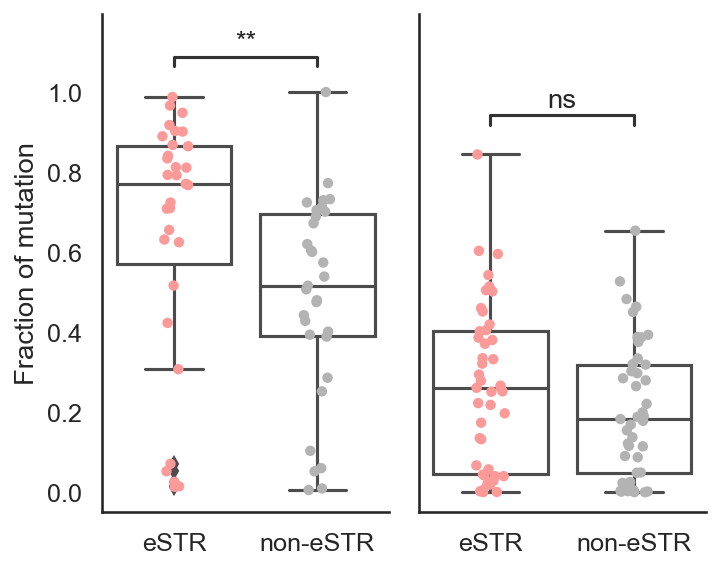

In [ ]:
## testing another way of visualization
fig, axes = plt.subplots(1, 2, figsize=(5, 4), tight_layout=True, sharey=True,
                         dpi = 150)
custom_params = {"axes.spines.top": False, "axes.spines.right": False}
sns.set_theme(style="white", rc = custom_params, font_scale = 1.1)
fig.subplots_adjust(hspace=0.3)

sns.boxplot(ax = axes[1],
    data = mss_mu, 
    boxprops={'facecolor':'None'},
    x = "type", y = "mu")
sns.stripplot(ax = axes[1],
    data = mss_mu, 
    x = "type", y = "mu",
    palette = [sns.color_palette("Paired")[4], 
               sns.color_palette("Set2")[-1]])
axes[1].set_xlabel("")
axes[1].set_xticklabels(["eSTR", "non-eSTR"])
axes[1].set_ylabel("")

sns.boxplot(ax = axes[0],
    data = msi_mu, 
    boxprops={'facecolor':'None'},
    x = "type", y = "mu")
sns.stripplot(ax = axes[0],
    data = msi_mu, 
    x = "type", y = "mu",
    palette = [sns.color_palette("Paired")[4], 
               sns.color_palette("Set2")[-1]])
axes[0].set_xlabel("")
axes[0].set_xticklabels(["eSTR", "non-eSTR"])
axes[0].set_ylabel("Fraction of mutation")

annot = Annotator(ax = axes[0], pairs = [("estr","nestr")], 
                  data = msi_mu, x = "type", y = "mu")
annot.configure(test='Mann-Whitney', text_format='star', loc='inside')
annot.apply_test().annotate()

annot = Annotator(ax = axes[1], pairs = [("estr","nestr")], 
                  data = mss_mu, x = "type", y = "mu")
annot.configure(test='Mann-Whitney', text_format='star', loc='inside')
annot.apply_test().annotate()

In [39]:
(com_msi["es_mu"] > (com_msi["ne_mu"] + 0.05)).sum(), com_msi.shape[0]

(29, 36)

In [71]:
(com_mss["es_mu"] > (com_mss["ne_mu"] + 0.05)).sum(),com_mss.shape[0]

(17, 48)

In [496]:
# 433
# eSTRs more mutable 25/31 in CRC MSI
# eSTRs more mutable 16/45 in CRC MSS
# 439
# eSTRs more mutable 10/17 in STAD MSI
# eSTRs more mutable 9/23 in STAD MSS
# 464
# eSTRs more mutable 9/16 in UCEC MSI
# eSTRs more mutable 4/17 in UCEC MSS

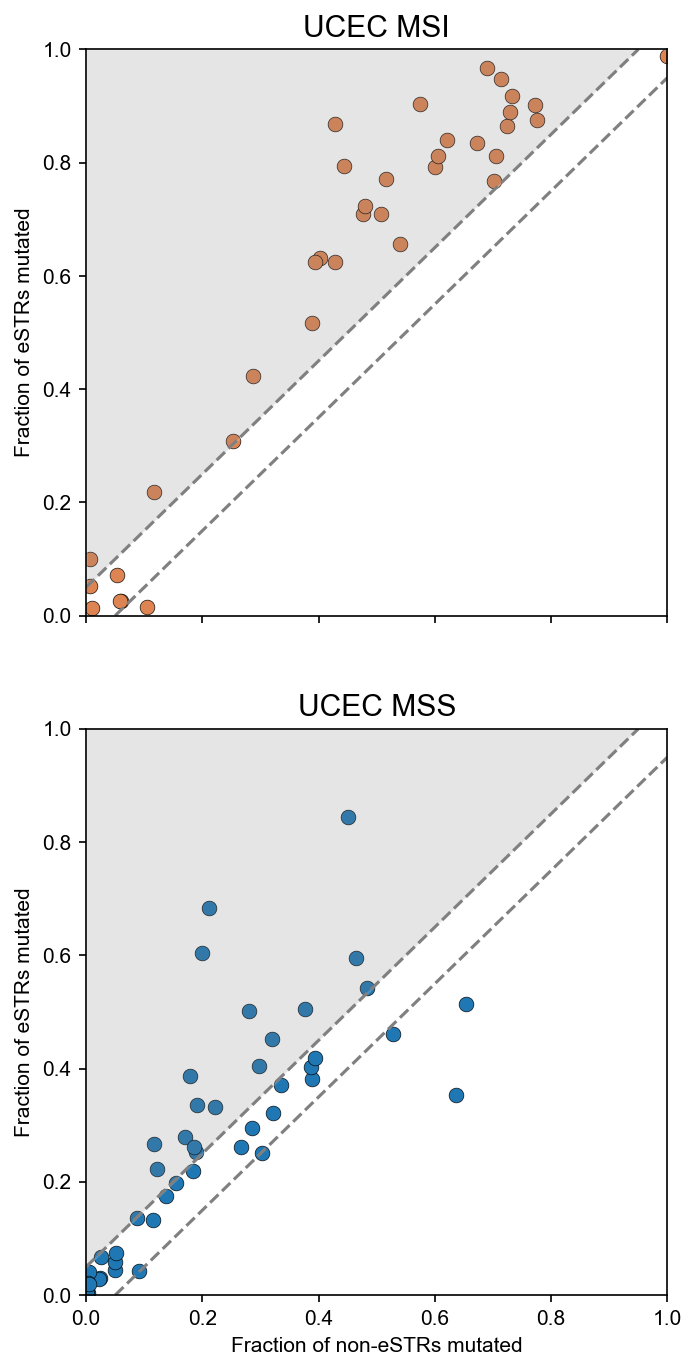

In [41]:
fig, axes = plt.subplots(2, 1, figsize=(5, 11), dpi = 150, sharex = True)
# custom_params = {"axes.spines.right": False, "axes.spines.top": False}
# sns.set_theme(style="white", rc=custom_params, font_scale = 1.1)
x1 = np.arange(0,1.1,0.1)
sns.set_theme(style="white", font_scale = 1.2)
sns.scatterplot(ax = axes[0], data = com_msi, x = "ne_mu", y = "es_mu", 
                s = 50,
                #alpha = 0.8,
                edgecolor = "black",
                linewidth = 0.3,
                color = sns.color_palette()[1])
axes[0].set_xlim(0,1)
axes[0].set_ylim(0,1)
axes[0].plot([0, 0.95], [0.05, 1], "--", color = "gray")
axes[0].plot([0.05, 1], [0, 0.95], "--", color = "gray")
axes[0].set_xlabel("Fraction of non-eSTRs mutated")
axes[0].set_ylabel("Fraction of eSTRs mutated")
axes[0].set_title("UCEC MSI")
axes[0].fill_between(x = x1, y1 = np.ones_like(x1), y2 = x1 + 0.05, 
                facecolor ='gray', alpha = 0.2)

sns.scatterplot(ax = axes[1], data = com_mss, x = "ne_mu", y = "es_mu",
                s = 50,
                #alpha = 0.8,
                edgecolor = "black",
                linewidth = 0.3,)
axes[1].set_xlim(0,1)
axes[1].set_ylim(0,1)
axes[1].plot([0, 0.95], [0.05, 1], "--", color = "gray")
axes[1].plot([0.05, 1], [0, 0.95], "--", color = "gray")
axes[1].set_xlabel("Fraction of non-eSTRs mutated")
axes[1].set_ylabel("Fraction of eSTRs mutated")
axes[1].set_title("UCEC MSS")
axes[1].fill_between(x = x1, y1 = np.ones_like(x1), y2 = x1 + 0.05, 
                facecolor ='gray', alpha = 0.2)

In [146]:
# permutation
all_num = crc_p.shape[0]
estr_num = crc_f.shape[0]
n_permutations = 1000
perm_diffs = np.zeros(n_permutations)
for i in range(n_permutations):
    print(i)
    random_estr = np.array(random.sample(range(all_num), estr_num))
    permutation_estr = crc_p.iloc[random_estr, ]
    permutation_nestr = crc_p.iloc[~crc_p.index.isin(random_estr),]

    df_estr = df_out.loc[df_out["tmp_id"].isin(permutation_estr["str_id"]),]
    df_nestr = df_out.loc[df_out["tmp_id"].isin(permutation_nestr["str_id"]),]

    df_estr_msi = df_estr.loc[df_estr["patient"].isin(msi_info.loc[msi_info["msi_status"] == "mss", "patient"])]
    df_nestr_msi = df_nestr.loc[df_nestr["patient"].isin(msi_info.loc[msi_info["msi_status"] == "mss", "patient"])]

    estr_msi_all = df_estr_msi.groupby(["period", "ref"])["tmp_id"].count().reset_index().query(" tmp_id > 50 ")
    estr_msi_mu = df_estr_msi.query(" patient_len_diff != 0 ").groupby(["period", "ref"])["tmp_id"].count().reset_index()
    type_es_msi = pd.merge(estr_msi_mu, estr_msi_all, on = ["period", "ref"])
    type_es_msi["es_mu"] = type_es_msi["tmp_id_x"]/type_es_msi["tmp_id_y"]

    nestr_msi_all = df_nestr_msi.groupby(["period", "ref"])["tmp_id"].count().reset_index().query(" tmp_id > 50 ")
    nestr_msi_mu = df_nestr_msi.query(" patient_len_diff != 0 ").groupby(["period", "ref"])["tmp_id"].count().reset_index()
    type_ne_msi = pd.merge(nestr_msi_mu, nestr_msi_all, on = ["period", "ref"])
    type_ne_msi["ne_mu"] = type_ne_msi["tmp_id_x"]/type_ne_msi["tmp_id_y"]

    com_msi = type_es_msi.merge(type_ne_msi, on = ["period", "ref"])
    
    perm_diffs[i] = ((com_msi["es_mu"] > (com_msi["ne_mu"] + 0.05)).sum())/com_msi.shape[0]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [147]:
p_value = np.sum(np.abs(perm_diffs) >= np.abs(16/45)) / n_permutations
p_value

0.003

In [148]:
pd.DataFrame(perm_diffs).to_csv("crc_mss_permutation.csv", index=False)

Text(0.01, 7.5, 'P = 0.003')

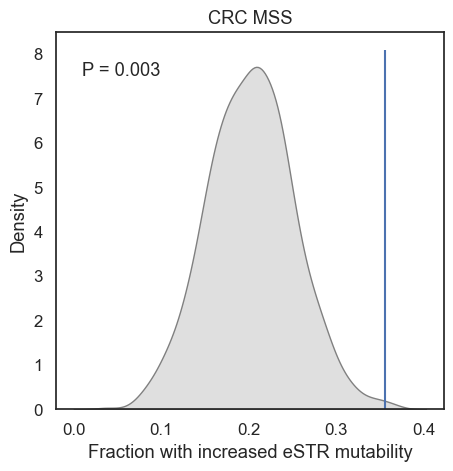

In [152]:
fig, axes = plt.subplots(1, 1, figsize=(5, 5), dpi = 100)
sns.set_theme(style = "white", font_scale = 1.1)
axes = sns.kdeplot(x = perm_diffs, 
                   fill = True, 
                   common_norm= False,
                   color = "grey")
axes.set_xlabel("Fraction with increased eSTR mutability")
axes.set_title("CRC MSS")

axes.vlines(x = 16/45, 
            ymin=0,
            ymax = axes.get_ylim()[1],
            color = sns.color_palette()[0])
axes.text(0.01, 7.5, "P = 0.003")

In [12]:
def mutation_calculate(df_str):
    df_indel = df_str[["tmp_id", "patient", "allele_a_diff", "allele_b_diff", "patient_len_diff", "msi_status"]].dropna(subset = ["msi_status"])
    df_somatic_deletions = (df_indel
                                .assign(
                                    allele_a_diff = lambda x: np.minimum(0, x.allele_a_diff),
                                    allele_b_diff = lambda x: np.minimum(0, x.allele_b_diff),
                                    patient_len_diff = lambda x: abs(x.allele_a_diff + x.allele_b_diff),
                                    mut_type = pd.Categorical(["deletion"] * len(df_indel))
                                ))
    df_barplot_deletions = (
        df_somatic_deletions
            .groupby("patient")
            .size()
            .reset_index()
    )
    df_barplot_deletions.columns = ["patient", "total_count"]

    df_barplot_deletions = df_barplot_deletions.merge(
        df_somatic_deletions[df_somatic_deletions["patient_len_diff"] > 0].groupby("patient").size().reset_index(),
        on="patient", how="left"
    )

    df_barplot_deletions.columns = ["patient", "total_count", "variable_count"]
    df_barplot_deletions["perc_loci_var"] = df_barplot_deletions["variable_count"] / df_barplot_deletions["total_count"] * 100
    df_barplot_deletions = df_barplot_deletions.merge(df_indel[["patient", "msi_status"]], on="patient", how="left")
    df_barplot_deletions = (
        df_barplot_deletions
            .drop_duplicates()
            .sort_values(by="perc_loci_var")
            .reset_index(drop=True)
            .assign(patient = lambda x: x.patient.apply(str))
    )
    df_somatic_insertions = (df_indel
                                .assign(
                                    allele_a_diff = lambda x: np.maximum(0, x.allele_a_diff),
                                    allele_b_diff = lambda x: np.maximum(0, x.allele_b_diff),
                                    patient_len_diff = lambda x: abs(x.allele_a_diff + x.allele_b_diff),
                                    mut_type = pd.Categorical(["insertion"] * len(df_indel))
                                ))
    df_barplot_insertions = (
        df_somatic_insertions
            .groupby("patient")
            .size()
            .reset_index()
    )
    df_barplot_insertions.columns = ["patient", "total_count"]

    df_barplot_insertions = df_barplot_insertions.merge(
        df_somatic_insertions[df_somatic_insertions["patient_len_diff"] > 0].groupby("patient").size().reset_index(),
        on="patient", how="left"
    )

    df_barplot_insertions.columns = ["patient", "total_count", "variable_count"]
    df_barplot_insertions["perc_loci_var"] = df_barplot_insertions["variable_count"] / df_barplot_insertions["total_count"] * 100
    # df_barplot_insertions = df_barplot_insertions.merge(df_clinical, on="patient", how="left")
    df_barplot_insertions = df_barplot_insertions.merge(df_indel[["patient", "msi_status"]], on="patient", how="left")
    df_barplot_insertions = (
        df_barplot_insertions
            .drop_duplicates()
            .sort_values(by="perc_loci_var")
            .reset_index(drop=True)
            .assign(patient = lambda x: x.patient.apply(str))
    )

    target_cols = []
    df_somatic_indels = pd.concat([
        df_barplot_deletions.assign(mut_type = pd.Categorical(["deletion"] * len(df_barplot_deletions), categories=["deletion", "insertion"])),
        df_barplot_insertions.assign(mut_type = pd.Categorical(["insertion"] * len(df_barplot_insertions), categories=["deletion", "insertion"]))
    ]).reset_index(drop=True)
    
    return df_somatic_indels

In [94]:
msi_info = pd.read_csv("../clinical/" + cancer_type + "_msi.csv")
msi_info.loc[msi_info["msi_status"] == "msi-l", "msi_status"] = "mss"
msi_info.loc[msi_info["msi_status"] == "indeterminate", "msi_status"] = "mss"
df_estr = df_estr.merge(msi_info, on = "patient", how="left")
df_ne_str = df_nestr.merge(msi_info, on = "patient", how = "left")

In [9]:
df_somatic_indels = mutation_calculate(df_estr)
df_ne_somatic = mutation_calculate(df_ne_str)

NameError: name 'df_estr' is not defined

In [105]:
com_str = pd.merge(df_somatic_indels.groupby("patient")["perc_loci_var"].sum().to_frame(),
                       df_ne_somatic.groupby("patient")["perc_loci_var"].sum().to_frame(), on = "patient")

In [109]:
com_str = com_str.merge(msi_info, on = "patient")

<AxesSubplot:xlabel='msi_status', ylabel='perc_loci_var_x'>

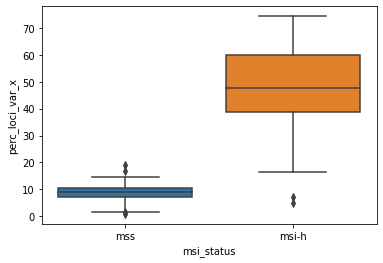

In [122]:
sns.boxplot(data = com_str, x = "msi_status", y = "perc_loci_var_x")

<AxesSubplot:xlabel='msi_status', ylabel='perc_loci_var_y'>

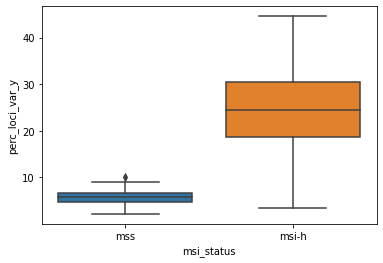

In [121]:
sns.boxplot(data = com_str, x = "msi_status", y = "perc_loci_var_y")

<AxesSubplot:xlabel='perc_loci_var_x', ylabel='perc_loci_var_y'>

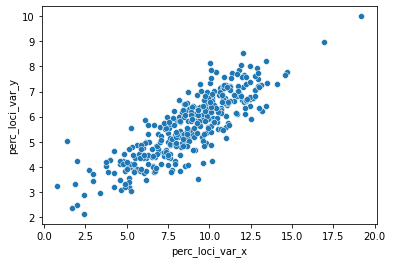

In [110]:
sns.scatterplot(data = com_str.loc[com_str["msi_status"] == "mss"], x = "perc_loci_var_x", y = "perc_loci_var_y")

In [116]:
df_mss_ne = df_ne_somatic.query(" msi_status == 'mss' ")
df_mss_es = df_somatic_indels.query(" msi_status == 'mss' ")
com_str_mss = pd.concat([df_mss_ne.groupby("patient")["perc_loci_var"].sum().to_frame(),
                       df_mss_es.groupby("patient")["perc_loci_var"].sum().to_frame()], ignore_index=True)

In [117]:
com_str_mss["estr"] = ["neSTR"]*int(df_mss_es.shape[0]/2) + ["eSTR"]*int(df_mss_es.shape[0]/2)

<AxesSubplot:xlabel='estr', ylabel='perc_loci_var'>

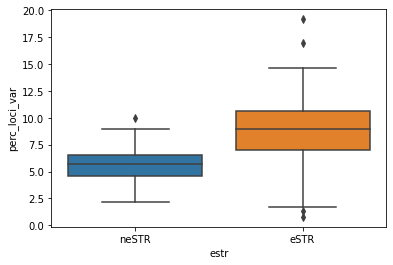

In [118]:
sns.boxplot(data = com_str_mss, x = "estr", y = "perc_loci_var")

<AxesSubplot:xlabel='estr', ylabel='perc_loci_var'>

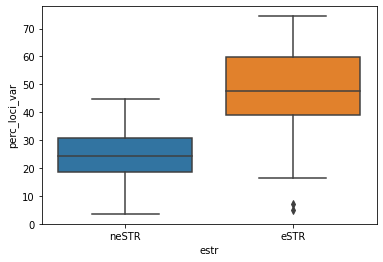

In [115]:
sns.boxplot(data = com_str_mss, x = "estr", y = "perc_loci_var")

<AxesSubplot:xlabel='perc_loci_var', ylabel='Count'>

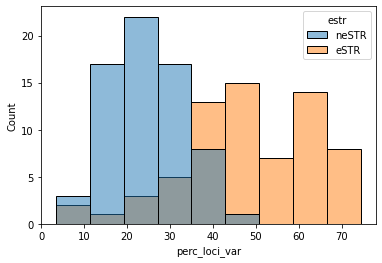

In [101]:
sns.histplot(data = com_str_mss, x = "perc_loci_var", hue = "estr")

In [167]:
df_somatic_indels.to_csv("crc_estr_mutation.csv", index = False)

## str mutation calculation

In [15]:
df_vstr = df_str.query("patient_len_diff != 0 ")

In [16]:
df_vstr.to_csv("./exp_paired/ucec_vstr.csv", index = False)

In [34]:
msi_info = pd.read_csv("../clinical/" + cancer_type + "_msi.csv")
msi_info.loc[msi_info["msi_status"] == "msi-l", "msi_status"] = "mss"
msi_info.loc[msi_info["msi_status"] == "indeterminate", "msi_status"] = "mss"
df_str = df_str.merge(msi_info, on = "patient", how="left")
df_somatic_indels = mutation_calculate(df_str)

In [36]:
df_somatic_indels.to_csv("./to_group/UCEC_STR_perc.csv", index = False)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

insertion_mss vs. insertion_msi-h: Mann-Whitney-Wilcoxon test two-sided, P_val:3.188e-07 U_stat=1.598e+04
deletion_mss vs. deletion_msi-h: Mann-Whitney-Wilcoxon test two-sided, P_val:1.072e-61 U_stat=7.530e+02


Text(0.5, 1.0, 'UCEC')

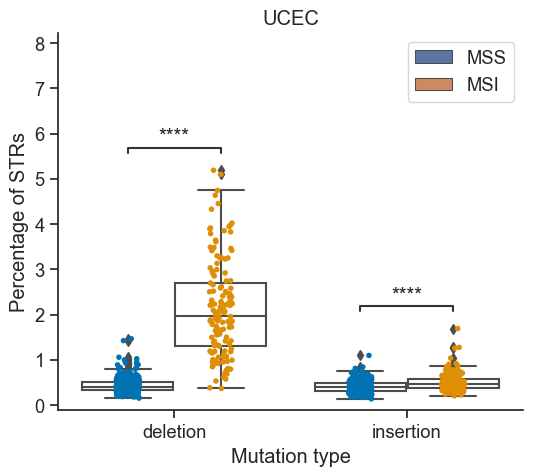

In [37]:
fig, axes = plt.subplots(1, 1, figsize=(6, 5), dpi = 100)
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params, font_scale = 1.2)

sns.boxplot(ax = axes,
    data = df_somatic_indels,
    x="mut_type",
    y="perc_loci_var",
    hue="msi_status",
    boxprops={'facecolor':'None'}
)
annot = Annotator(ax = axes, pairs = [(("deletion", "mss"), ("deletion", "msi-h")), 
                                         (("insertion", "mss"), ("insertion", "msi-h"))], hue = "msi_status",
                  data = df_somatic_indels, x = "mut_type", y = "perc_loci_var")
annot.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
annot.apply_test().annotate()

handles = axes.legend_.legendHandles
labels = [text.get_text() for text in axes.legend_.texts]

sns.stripplot(ax = axes,
    data = df_somatic_indels,
    x="mut_type",
    y="perc_loci_var",
    hue="msi_status",
    palette="colorblind",
    dodge=True,
    color="black",
    s=4
)

axes.set(
    xlabel="Mutation type",
    ylabel="Percentage of STRs",    
    ylim=(None, axes.get_ylim()[1] + 2),
)

legend_handles, _ = axes.get_legend_handles_labels()
axes.legend(legend_handles, ["MSS", "MSI"], 
           bbox_to_anchor=(1,1))
axes.set_title(cancer_type)

In [149]:
df_somatic_indels["msi_status"].value_counts()/2

mss      323.0
msi-h    141.0
Name: msi_status, dtype: float64

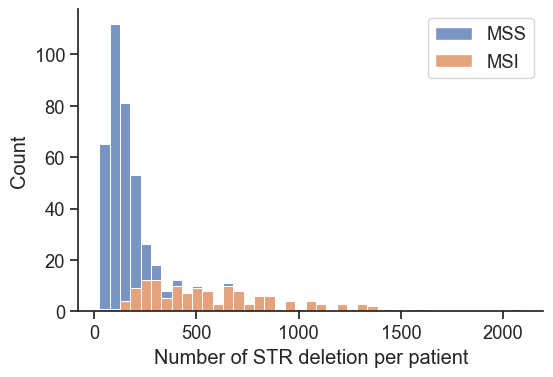

In [150]:
fig, axes = plt.subplots(1, 1, figsize=(6, 4), dpi = 100)
sns.histplot(ax = axes, data = df_somatic_indels.query("mut_type == 'deletion'"),
             x = "variable_count", hue = "msi_status", multiple="stack")
axes.set_xlabel("Number of STR deletion per patient")
old_legend = axes.legend_
handles = old_legend.legendHandles
axes.legend(handles, ["MSS", "MSI"])

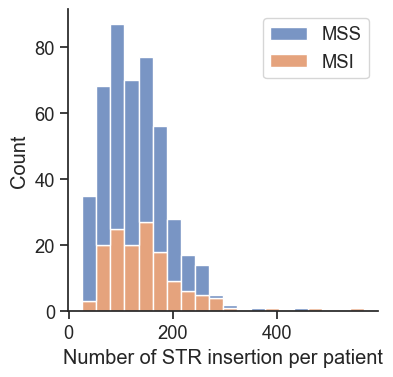

In [151]:
fig, axes = plt.subplots(1, 1, figsize=(4, 4), dpi = 100)
axes = sns.histplot(data = df_somatic_indels.query("mut_type == 'insertion'"),
             x = "variable_count", hue = "msi_status", multiple="stack", bins = 20, hue_order=["mss", "msi-h"])
axes.set_xlabel("Number of STR insertion per patient")
old_legend = axes.legend_
handles = old_legend.legendHandles
axes.legend(handles, ["MSS", "MSI"])